# ADDITIONAL FEATURE DESIGN
Author: Jaime Pastor

The goal of this notebook is to create additional features to attempt improve the classifier by the winner of the Kaggle competition.

## PART 1: Average spectrogram of each class

The winner of the competition extracted templates of whale/non-whale spectrograms by choosing them subjectively (looking at the plots).

A less arbitrary process might be benefitial. To do so, we calculate the average of the spectrogram of each class, after processing it with the horizontal and vertical treatment.

In [16]:
import aifc
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import mlab, cm
import numpy as np
import pandas as pd
%matplotlib inline

In [17]:
path_data = '/Users/jaime/Documents/datasets/mlprojectdata/data/'

# Read the labels of the training set
dfindex = pd.read_csv(path_data+'training_index.csv')
print len(dfindex)
dfindex[0:5]

24084


,File,Class
0,train6.aiff,1
1,train7.aiff,1
2,train9.aiff,1
3,train12.aiff,1
4,train28.aiff,1


In [18]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

# Vertical treatment (contrast enhancement, normalization, local-mean removal)
def slidingWindowV(P,inner=3,outer=64,maxM = 50,norm=True):
    Q = P.copy()
    m, n = Q.shape
    if norm:
        mval, sval = np.mean(Q[:maxM,:]), np.std(Q[:maxM,:])
        fact_ = 1.5
        Q[Q > mval + fact_*sval] = mval + fact_*sval
        Q[Q < mval - fact_*sval] = mval - fact_*sval
    wInner = np.ones(inner)
    wOuter = np.ones(outer)
    for i in range(n):
        Q[:,i] = Q[:,i] - (np.convolve(Q[:,i],wOuter,'same') - np.convolve(Q[:,i],wInner,'same'))/(outer - inner)
    return Q

# Horizontal treatment
def slidingWindowH(P,inner=3,outer=32,maxM=50,norm=True):
    Q = P.copy()
    m, n = Q.shape
    if norm:
        mval, sval = np.mean(Q[:maxM,:]), np.std(Q[:maxM,:])
        fact_ = 1.5
        Q[Q > mval + fact_*sval] = mval + fact_*sval
        Q[Q < mval - fact_*sval] = mval - fact_*sval
    wInner = np.ones(inner)
    wOuter = np.ones(outer)
    for i in range(maxM):
        Q[i,:] = Q[i,:] - (np.convolve(Q[i,:],wOuter,'same') - np.convolve(Q[i,:],wInner,'same'))/(outer - inner)
    return Q

# Compute average of each class
def build_average_class(path_data, dfindex):
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192} 
    TV1, TV0, TH1, TH0 = [np.zeros((129,59)) for x in range(4)]
    n1, n0 = 0, 0 
    for i in range(len(dfindex)):
        filei = dfindex.ix[i,0]
        labeli = dfindex.ix[i,1]
        s = ReadAIFF(path_data + 'train/' + filei)
        P, freqs, bins = mlab.specgram(s, **params)
        QV = slidingWindowV(P,inner=3,maxM=40)
        QH = slidingWindowH(P,inner=3,outer=32,maxM=60)

        if labeli == 1:
            TV1 += QV
            TH1 += QH
            n1 += 1
        else:
            TV0 += QV
            TH0 += QH
            n0 += 1
        
    TV1 = TV1 / float(n1)
    TV0 = TV0 / float(n0)
    TH1 = TH1 / float(n1)
    TH0 = TH0 / float(n0)
    return TV1, TV0, TH1, TH0

def plot_spectrogram(ax, P):
    plt.imshow(P, origin='lower', extent=[-6,6,-1,1], aspect=4, cmap = cm.get_cmap('bwr'))
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.set_xticklabels(np.arange(-0.5,2.5,0.5))
    ax.set_yticklabels(range(0,1001,250))
    ax.set_xlabel('Time (seconds)', fontsize = 12)
    ax.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)

def plot_side_by_side(P,Q,title1):
    fig = plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    plot_spectrogram(ax1, P)
    ax2 = plt.subplot(122)
    plot_spectrogram(ax2, Q)
    plt.suptitle(title1, fontsize = 16)
    plt.show()

In [19]:
TV1, TV0, TH1, TH0 = build_average_class(path_data, dfindex)

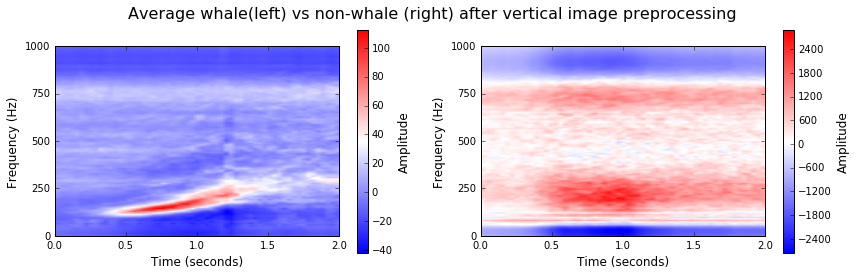

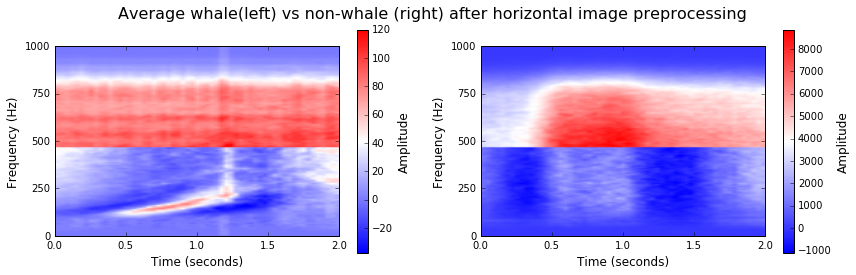

In [21]:
title1 = 'Average whale(left) vs non-whale (right) after vertical image preprocessing'
title2 = 'Average whale(left) vs non-whale (right) after horizontal image preprocessing'
plot_side_by_side(TV1, TV0, title1)
plot_side_by_side(TH1, TH0, title2)

## PART 2: Extracting generic templates

Now we can isolate the shape of the whale/non-whale sound in the spectrogram and use template matching as a feature (maximum correlation and location of the match).

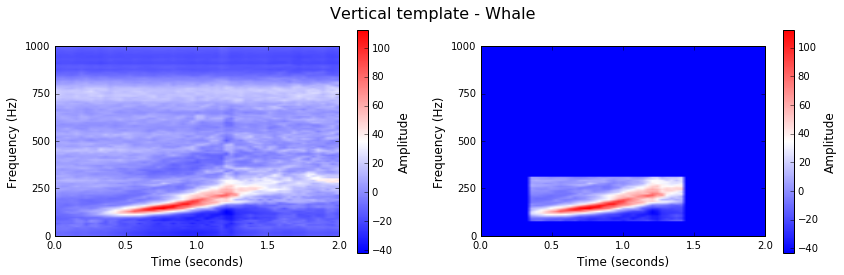

In [23]:
# VERTICAL WHALE
R = TV1.copy()
set_val = R.min() - 1
x0, xn, y0, yn = 10, 40, 10, 42
R[0:x0,:], R[xn:130,:] = set_val, set_val
R[:,0:y0], R[:,yn:60] = set_val, set_val
plot_side_by_side(TV1, R, 'Vertical template - Whale')
t1v = R[x0:xn,y0:yn]
x1v = [x0, xn, y0, yn]

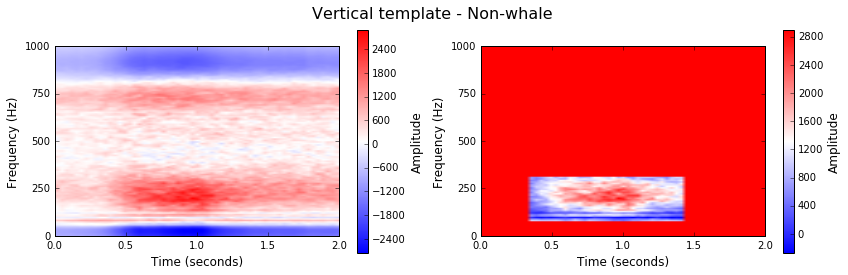

In [7]:
# VERTICAL NON-WHALE
R = TV0.copy()
set_val = R.max() + 1
x0, xn, y0, yn = 10, 40, 10, 42
R[0:x0,:], R[xn:130,:] = set_val, set_val
R[:,0:y0], R[:,yn:60] = set_val, set_val
plot_side_by_side(TV0, R, 'Vertical template - Non-whale')
t0v = R[x0:xn,y0:yn]
x0v = [x0, xn, y0, yn]

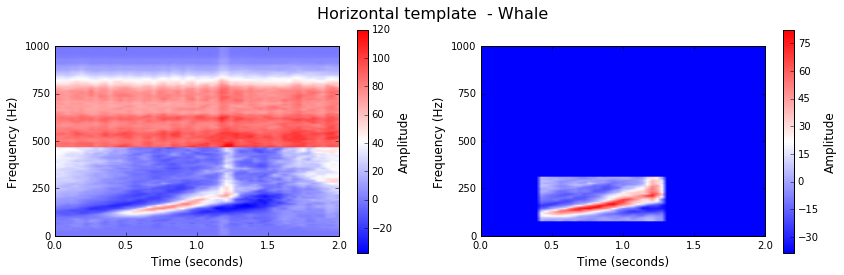

In [8]:
R = TH1.copy()
set_val = R.min() - 1
x0, xn, y0, yn = 10, 40, 12, 38
R[0:x0,:], R[xn:130,:] = set_val, set_val
R[:,0:y0], R[:,yn:60] = set_val, set_val
plot_side_by_side(TH1, R, 'Horizontal template  - Whale')
t1h = R[x0:xn,y0:yn]
x1h = [x0, xn, y0, yn]

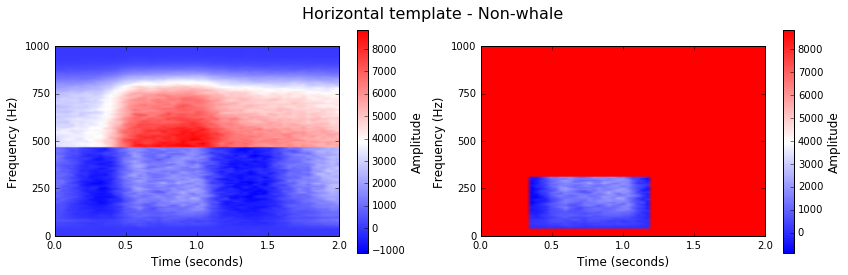

In [9]:
R = TH0.copy()
set_val = R.max() + 1
x0, xn, y0, yn = 5, 40, 10, 35
R[0:x0,:], R[xn:130,:] = set_val, set_val
R[:,0:y0], R[:,yn:60] = set_val, set_val
plot_side_by_side(TH0, R, 'Horizontal template - Non-whale')
t0h = R[x0:xn,y0:yn]
x0h = [x0, xn, y0, yn]

Now that we have the templates, we can check the final output after normalization (binary mask)

In [10]:
def normalize(P):
    tmpl = P.copy()
    m_, s_ = np.mean(tmpl), np.std(tmpl)
    min_ = tmpl.min()
    tmpl[ tmpl < m_ + 0.5*s_] = min_ 
    tmpl[ tmpl > min_ ] = 1
    tmpl[tmpl < 0] = 0
    return tmpl

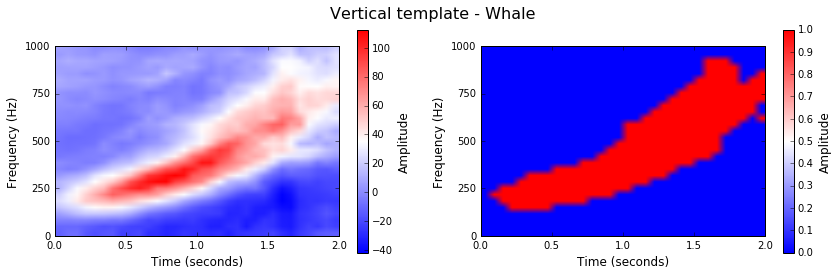

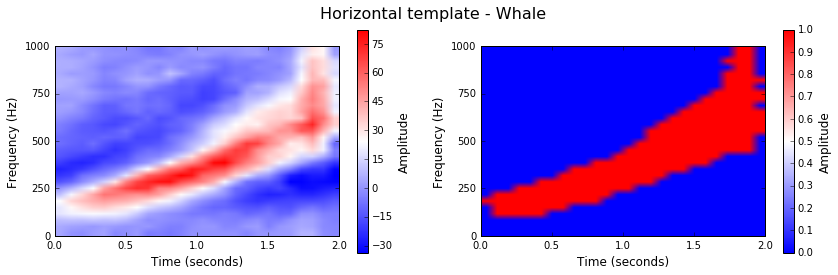

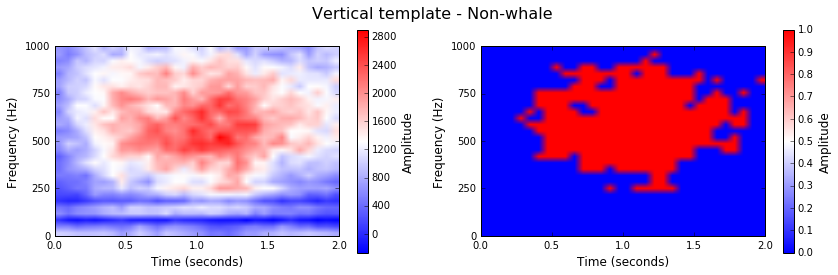

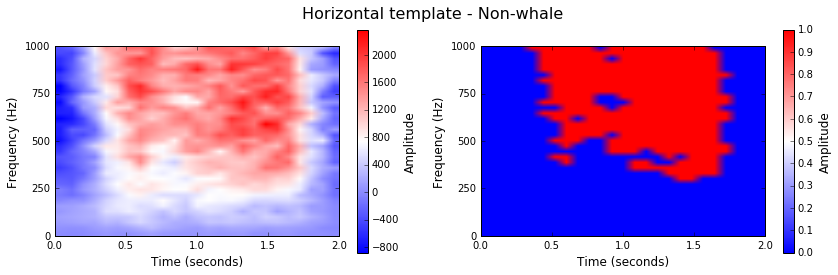

In [12]:
plot_side_by_side(t1v, normalize(t1v), 'Vertical template - Whale')
plot_side_by_side(t1h, normalize(t1h), 'Horizontal template - Whale')
plot_side_by_side(t0v, normalize(t0v), 'Vertical template - Non-whale')
plot_side_by_side(t0h, normalize(t0h), 'Horizontal template - Non-whale')

In [23]:
# Save them to csv
xloc = np.array([x1v,x0v, x1h, x0h])
np.savetxt("TV1.csv", TV1, delimiter=",")
np.savetxt("TV0.csv", TV0, delimiter=",")
np.savetxt("TH1.csv", TH1, delimiter=",")
np.savetxt("TH0.csv", TH0, delimiter=",")
np.savetxt("xloc.csv", xloc, delimiter=",")

# PART 3: Metrics
Now that we have the templates, we can modify the code to include additional metrics. 
This means mainly adding new functions to metrics.py

- Match the four templates with the target spectrogram and extract 3 values per template: maximum correlation and location of the match (2)
- Compute the distance between the whole spectrogram of the target image and the average spectrogram of each class after horizontal and vertical treatment (4 values per image)